# Solution of the deer data

** Try first yourself before continuing **
### Count regression on deer data

This notebook demonstrates the use of TFP for regression on count data. The dataset is the number of fish caught in a state park. 

* Poisson Regression
* Zero Infated Poisson Regression

#### Results from the paper

In [0]:
EPOCHS = 15
HIGHMEN = False #Also excute code with needs RAM 

In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
  
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0
TF  Version 2.0.0-alpha0


## Loading some count data

In [0]:
# Alternative version
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/nb_data.csv') 
# X = dat[...,0:3]
# y = dat[...,4]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [0]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
#dat = np.loadtxt('../data/fish.csv', delimiter=',', skiprows=1)
# dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
# X = dat[...,1:5] #"livebait","camper","persons","child
# y = dat[...,7]
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
# d = X_tr.shape[1]
# X_tr.shape, y_tr.shape, X_te.shape, y_te.shape,dat.shape

In [0]:
#!wget http://www-home.htwg-konstanz.de/~oduerr/tmp/deer_train_short.csv

In [0]:
try:
    import feather
except:
    !pip install feather-format
    import feather

In [0]:
from urllib.request import urlretrieve
import os
def get_if_not_there(filename = 'deer_train.feather'):
    if not os.path.isfile(filename):
         urlretrieve('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/{}'.format(filename),
                    filename = filename)

get_if_not_there('deer_train.feather')
get_if_not_there('deer_test.feather')

In [9]:
import pandas as pd
import numpy as np
df_train = feather.read_dataframe('deer_train.feather')
df_test = feather.read_dataframe('deer_test.feather')
df_test[0:2]

,wild,year,time,daytime,weekday
0,0,2010.0,2922.000000,night.am,Sunday
1,2,2010.0,2922.020833,night.am,Sunday


In [0]:
y_tr = df_train.iloc[:,0].to_numpy(dtype='float32')
y_te = df_test.iloc[:,0].to_numpy(dtype='float32')
X_tr = pd.get_dummies(df_train.iloc[:,2:]) #We don't need the year
X_te = pd.get_dummies(df_test.iloc[:,2:])
X_tr.iloc[:,0] = X_tr.iloc[:,0]/2922.02    #We divide by the maximal number to something in the range 0 to 1
X_te.iloc[:,0] = X_te.iloc[:,0]/2922.02 
del df_train, df_test

In [11]:
X_tr[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.000007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
X_te[0:2]

,time,daytime_day.am,daytime_night.am,daytime_pre.sunrise.am,daytime_post.sunrise.am,daytime_day.pm,daytime_night.pm,daytime_pre.sunset.pm,daytime_post.sunset.pm,weekday_Monday,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday
0,0.999993,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
X_tr = X_tr.to_numpy(dtype='float32')
X_te = X_te.to_numpy(dtype='float32')
d = X_te.shape[1]
# In R
#> sum(df.train$wild);sum(df.test$wild)
#[1] 265911
#[1] 75744
np.sum(y_te),np.sum(y_tr),X_tr.shape

(75744.0, 265911.0, (140256, 16))

In [0]:
#### Some exploratory analysis

38.0

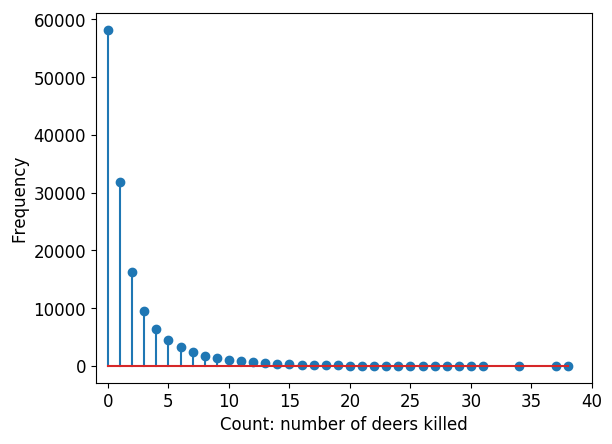

In [15]:
plt.style.use('default')
plt.rcParams.update({'font.size': 12})
vals, counts = np.unique(y_tr, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.savefig('ch05_deer.pdf')
np.max(y_tr)

# <------ Cut here for the solution file --->

## 1 Doing linear regression

In this section we do a standard linear regression.

In [0]:
model_lr = tf.keras.Sequential() #A
model_lr.add(tf.keras.layers.Dense(1,input_dim=d, activation='linear')) #B 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))

In [17]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=EPOCHS, verbose=True);
#hist_lr = model_lr.fit(x=X_tr, y=np.sqrt(y_tr), validation_data=(X_te, y_te), epochs=600, verbose=False);

Train on 140256 samples, validate on 35040 samples
Epoch 1/15
140256/140256 [==============================] - 7s 48us/sample - loss: 6.6228 - val_loss: 8.3269
Epoch 2/15
140256/140256 [==============================] - 6s 44us/sample - loss: 6.5369 - val_loss: 8.3572
Epoch 3/15
140256/140256 [==============================] - 6s 45us/sample - loss: 6.5378 - val_loss: 8.3768
Epoch 4/15
140256/140256 [==============================] - 6s 45us/sample - loss: 6.5363 - val_loss: 8.3224
Epoch 5/15
140256/140256 [==============================] - 6s 44us/sample - loss: 6.5373 - val_loss: 8.3355
Epoch 6/15
140256/140256 [==============================] - 6s 44us/sample - loss: 6.5368 - val_loss: 8.3643
Epoch 7/15
140256/140256 [==============================] - 6s 44us/sample - loss: 6.5375 - val_loss: 8.3554
Epoch 8/15
140256/140256 [==============================] - 6s 45us/sample - loss: 6.5362 - val_loss: 8.3262
Epoch 9/15
140256/140256 [==============================] - 6s 45us/sample - 

6.5427484298959975

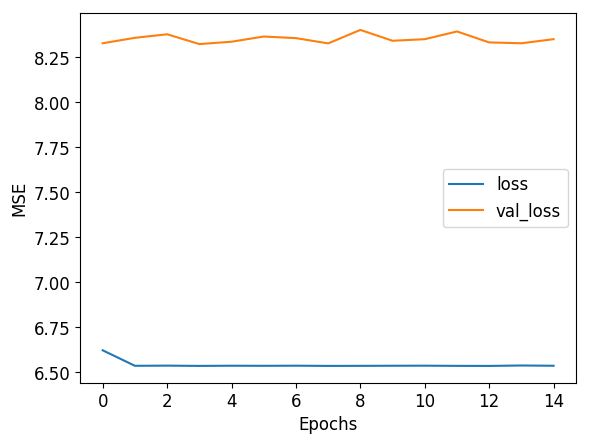

In [18]:
plt.plot(hist_lr.history['loss'])
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [0]:
if (HIGHMEN):
  y_hat_te = model_lr.predict(X_te)
  print(np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te)))
  plt.scatter(y_te, y_hat_te**2)
  plt.xlabel('True ')
  plt.ylabel('Predicted ')
  y_hat_tr = model_lr.predict(X_tr) #Testset
  sigma_hat_2 = np.var(y_hat_tr.flatten() - y_tr) 
  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_hat_te - y_te)**2)/sigma_hat_2

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [20]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
h = tf.keras.layers.Dense(30, 
         activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(100, 
         activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(100, 
         activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(10, 
         activation='relu')(h)
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(h)

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.001), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.

model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                510       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0     

In [21]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=EPOCHS, verbose=True);

Train on 140256 samples, validate on 35040 samples
Epoch 1/15
140256/140256 [==============================] - 13s 90us/sample - loss: 1.9821 - val_loss: 2.0434
Epoch 2/15
140256/140256 [==============================] - 12s 88us/sample - loss: 1.9146 - val_loss: 2.0591
Epoch 3/15
140256/140256 [==============================] - 13s 90us/sample - loss: 1.9028 - val_loss: 2.0402
Epoch 4/15
140256/140256 [==============================] - 12s 88us/sample - loss: 1.8969 - val_loss: 2.0448
Epoch 5/15
140256/140256 [==============================] - 12s 87us/sample - loss: 1.8939 - val_loss: 2.0460
Epoch 6/15
140256/140256 [==============================] - 12s 88us/sample - loss: 1.8915 - val_loss: 2.0360
Epoch 7/15
140256/140256 [==============================] - 12s 87us/sample - loss: 1.8920 - val_loss: 2.0352
Epoch 8/15
140256/140256 [==============================] - 12s 88us/sample - loss: 1.8904 - val_loss: 2.0355
Epoch 9/15
140256/140256 [==============================] - 12s 88us/

2.0431637420465596

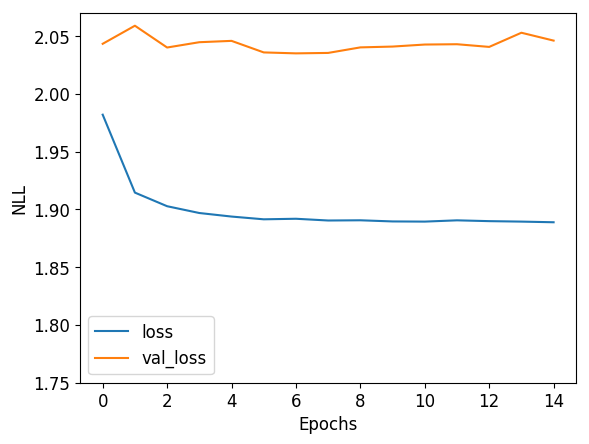

In [22]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
np.mean(hist_p.history['loss'])
plt.ylim(1.75,2.07)
np.mean(hist_p.history['val_loss'][-20:]) #Paper -1.91760131278

In [0]:
if (HIGHMEN):
  model_pm = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) 
  y_hat_te = model_pm(X_te).numpy()
  y_hat_te
  np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te)) 

## 2 Poisson regression with linear models 

In [0]:
# First build the model matrix, appending an intercept term
# d = np.shape(X_tr)[1]
# Xm = np.ones((np.shape(X_tr)[0],d+1))
# Xm[:,1:d+1] = X_tr

In [0]:
# d = np.shape(X_te)[1]
# X_te_in = np.ones((np.shape(X_te)[0],d+1), dtype='float32')
# X_te_in[:,1:d+1] = X_te

In [0]:
# fit = tfp.glm.fit(
#     model_matrix=Xm,
#     response=y_tr,
#     model=tfp.glm.Poisson()
# )

$$
\lambda = exp(X \cdot \hat \beta)
$$

In [0]:
# d = np.matmul(X_te_in,fit[0])
# lam = np.exp(d)
#dd = tfd.Poisson(lam).log_prob(y_te).numpy()
#print(np.mean(dd) - -1.917601) #-1.917601 according to R
# plt.figure(figsize=(6,6))
# plt.xlim(-0.1,5)
# plt.ylim(-0.1,5)
# y_hat_tr = model_pm(X_tr)
# plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
# plt.xlabel('Counts: predicted by Poisson')
# plt.ylabel('Counts: true')
# plt.savefig('ch05_pois.pdf')
# print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
# print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

## 3 Using zero inflated Poisson Regression

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

### Definition of the distribution

In [0]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

### Definition of the model

In [29]:
## Definition of the model
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
## Definition of the custom parametrized distribution
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
h = tf.keras.layers.Dense(500, activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(100, activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(10, activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)

out = Dense(2,  #A
            kernel_regularizer=l2(0.01), #B
            bias_regularizer=l2(0.01))(h)#B

p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
#B Using a regularisation prevents the network from learning too large weights. Without regularisation, you run into numerical problems.
model_zi.summary()

W0714 12:30:26.316057 140489400952704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_1/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               8500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________


### Training of the model (by hand) [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, which we got rid off using regularisation. See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [0]:
# optimizer=tf.optimizers.RMSprop(learning_rate=0.05)
# loss_values = np.zeros((1000))
# for e in range(10):
#     with tf.GradientTape() as tape:
#         y_hat = model_zi(X_tr)
#         loss_value = -tf.reduce_mean(y_hat.log_prob(y_tr))
#         loss_values[e] = loss_value
#         grads = tape.gradient(loss_value, model_zi.trainable_weights)
#         weights =  model_zi.trainable_weights       
#         optimizer.apply_gradients(zip(grads,weights))

### Training using keras' build in training

In [31]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik2)
hist_zi = model_zi.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=EPOCHS, verbose=True)#, callbacks=[tb]);

Train on 140256 samples, validate on 35040 samples
Epoch 1/15
140256/140256 [==============================] - 17s 124us/sample - loss: 1.8933 - val_loss: 1.9341
Epoch 2/15
140256/140256 [==============================] - 17s 121us/sample - loss: 1.8422 - val_loss: 1.9309
Epoch 3/15
140256/140256 [==============================] - 17s 119us/sample - loss: 1.8392 - val_loss: 1.9375
Epoch 4/15
140256/140256 [==============================] - 17s 121us/sample - loss: 1.8359 - val_loss: 1.9253
Epoch 5/15
140256/140256 [==============================] - 17s 119us/sample - loss: 1.8311 - val_loss: 1.9297
Epoch 6/15
140256/140256 [==============================] - 17s 119us/sample - loss: 1.8320 - val_loss: 1.9210
Epoch 7/15
140256/140256 [==============================] - 17s 122us/sample - loss: 1.8301 - val_loss: 1.9355
Epoch 8/15
140256/140256 [==============================] - 17s 122us/sample - loss: 1.8307 - val_loss: 1.9313
Epoch 9/15
140256/140256 [==============================] - 1

(1.919754906005511, 1.926263478814739)

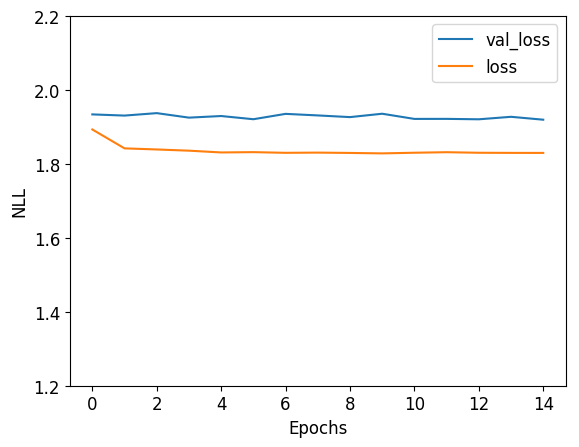

In [32]:
#plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_zi.history['val_loss'])
#plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['loss'])
plt.ylim(1.2,2.2)
#plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.legend(['val_loss','loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.savefig('ch05_flik.pdf')
#np.mean(hist_p.history['val_loss'][-30:]) ,
np.min(hist_zi.history['val_loss']) ,np.mean(hist_zi.history['val_loss'][-10:]) 

In [0]:
# model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_zi.mean())
# y_hat_te = model_zi(X_te)
# #mean_absolute_error(y_hat_te, y_te), mean_squared_error(y_hat_te, y_te)
# np.sqrt(np.mean((y_hat_te - y_te)**2)),np.mean(np.abs(y_hat_te - y_te))

In [0]:
if HIGHMEN:
  plt.figure(figsize=(6,6))
  plt.xlim(-1,5)
  plt.ylim(-1,5)
  y_hat_tr = model_zi(X_tr)

  plt.scatter(y_hat_te, np.random.normal(loc=y_te,scale=0.2), alpha=0.7)
  plt.xlabel('Counts: predicted by ZI (Training)')
  plt.ylabel('Counts: true')

  plt.savefig('ch05_zi.pdf')
  print('Training Set', np.mean(np.square(y_hat_tr[y_tr == 0])),np.sum(y_hat_tr[y_tr == 0]>0.5))
  print('Validation Set', np.mean(np.square(y_hat_te[y_te == 0])),np.sum(y_hat_te[y_te == 0]>0.5))

## 4 Using Mixture Models

In [0]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

In [0]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def mixture_discrete(out, bits=6, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = 0.5 + tf.nn.softplus(un_scale)
    
    distribution=tfd.TransformedDistribution(
        #distribution=tfd.Poisson(rate=scale),
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)
    )
       
    
    discretized_logistic_dist = tfd.QuantizedDistribution(distribution, low=0.,high=2**bits - 1.)
    
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [0]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def nvp_discrete(out, bits=6, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = 0.5 + tf.nn.softplus(un_scale)
    
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.RealNVP(
        num_masked=2,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(
            hidden_layers=[16, 16]))
    )
       
    
    discretized_logistic_dist = tfd.QuantizedDistribution(distribution, low=0.,high=2**bits - 1.)
   
    return discretized_logistic_dist

In [38]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
h = tf.keras.layers.Dense(50, activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(500, activation='relu')(inputs)
h = tf.keras.layers.Dropout(0.1)(h)
h = tf.keras.layers.Dense(100, activation='relu')(h)
h = tf.keras.layers.Dropout(0.2)(h)
h = tf.keras.layers.Dense(100, activation='relu')(h)
h = tf.keras.layers.Dropout(0.3)(h)
h = tf.keras.layers.Dense(9, activation='relu')(h)
#tt = tf.concat([loc1, scales1, logits], axis=1)
p_y = tfp.layers.DistributionLambda(mixture_discrete)(h) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
#model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(0.01), loss=negloglik2)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               8500      
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               50100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0   

### Results

In [39]:
hist = model.fit(X_tr, y_tr, epochs=EPOCHS, verbose=1, validation_data=(X_te, y_te))

Train on 140256 samples, validate on 35040 samples
Epoch 1/15
140256/140256 [==============================] - 21s 149us/sample - loss: 1.6799 - val_loss: 1.7494
Epoch 2/15
140256/140256 [==============================] - 21s 146us/sample - loss: 1.6743 - val_loss: 1.7551
Epoch 3/15
140256/140256 [==============================] - 21s 150us/sample - loss: 1.6747 - val_loss: 1.7686
Epoch 4/15
140256/140256 [==============================] - 21s 146us/sample - loss: 1.6831 - val_loss: 1.7539
Epoch 5/15
140256/140256 [==============================] - 20s 146us/sample - loss: 1.6718 - val_loss: 1.7691
Epoch 6/15
140256/140256 [==============================] - 20s 145us/sample - loss: 1.6727 - val_loss: 1.7527
Epoch 7/15
140256/140256 [==============================] - 20s 145us/sample - loss: 1.6752 - val_loss: 1.7476
Epoch 8/15
140256/140256 [==============================] - 20s 145us/sample - loss: 1.6770 - val_loss: 1.7716
Epoch 9/15
140256/140256 [==============================] - 2

1.7627262576348521

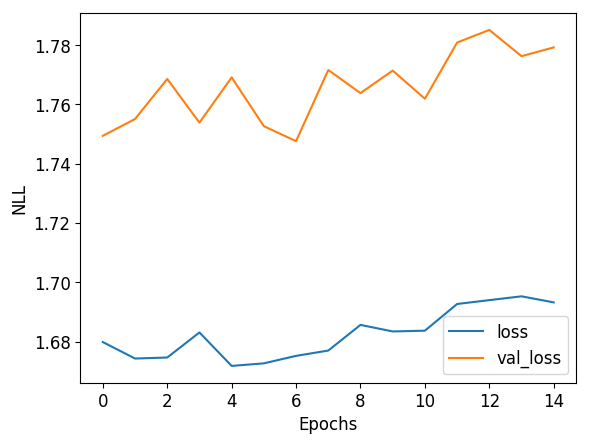

In [41]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
np.mean(hist.history['loss'])
#plt.ylim(1.5,1.7)
np.mean(hist.history['val_loss'][4:10]) 